In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import speech_features.load_wav_files as lw
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Features Extraction

In [2]:
words = {'bed'}

In [3]:
x_train_clean, y_train = lw.load_dataset("speech_commands_v0.01", words, 'mfcc', 0, 'training', 1, 0, 10)
x_train_noisy, _ = lw.load_dataset("speech_commands_v0.01", words, 'mfcc', 1, 'training', 1, 0, 10)

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [4]:
x_test_noisy, y_test = lw.load_dataset("speech_commands_v0.01", words, 'mfcc', 0.25, 'testing', 1, 0, 10)
x_test_clean, _ = lw.load_dataset("speech_commands_v0.01", words, 'mfcc', 0, 'testing', 1, 0, 10)

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(1516, 99, 12)
933
20.0


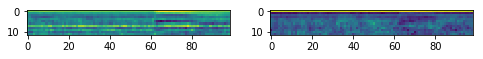

In [4]:
print(x_train_clean.shape)
index = np.random.randint(x_train_clean.shape[0])
print(index)
print(y_train[index])
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(np.transpose(x_train_clean[index]))
fig.add_subplot(1, 2, 2)
plt.imshow(np.transpose(x_train_noisy[index]))
plt.show()

In [6]:
np.save('x_test_clean', x_test_clean)
np.save('x_test_noisy', x_test_noisy)
np.save('y_test', y_test)

In [7]:
np.save('x_training_clean', x_train_clean, allow_pickle = False)
np.save('x_training_noisy', x_train_noisy, allow_pickle = False)
np.save('y_training', y_train, allow_pickle = False)

# Loading the desired dataset

In [3]:
x_test_clean = np.load('x_test_clean.npy')
x_test_noisy = np.load('x_test_noisy.npy')
y_test = np.load('y_test.npy')

In [4]:
x_train_clean = np.load('x_training_clean.npy', allow_pickle = False)
x_train_noisy = np.load('x_training_noisy.npy', allow_pickle = False)
y_train = np.load('y_training.npy', allow_pickle = False)

# Reshape dataset

In [5]:
feat_rows = x_train_clean.shape[1]
feat_cols = x_train_clean.shape[2]
feats_shape = (feat_rows, feat_cols, 1)

x_test_clean = x_test_clean / (np.max(x_test_clean) + 1)
x_test_noisy = x_test_noisy / (np.max(x_test_noisy) + 1)
x_train_clean = x_train_clean / (np.max(x_train_clean) + 1)
x_train_noisy = x_train_noisy / (np.max(x_train_noisy) + 1)


x_train_clean = x_train_clean.reshape(x_train_clean.shape[0], *feats_shape)
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0], *feats_shape)
x_test_clean = x_test_clean.reshape(x_test_clean.shape[0], *feats_shape)
x_test_noisy = x_test_noisy.reshape(x_test_noisy.shape[0], *feats_shape)

print('x_train_clean shape: {}'.format(x_train_clean.shape))
print('x_train_noisy shape: {}'.format(x_train_noisy.shape))
print('x_test_clean shape: {}'.format(x_test_clean.shape))
print('x_test_noisy shape: {}'.format(x_test_noisy.shape))



x_train_clean shape: (16929, 99, 12, 1)
x_train_noisy shape: (16929, 99, 12, 1)
x_test_clean shape: (2021, 99, 12, 1)
x_test_noisy shape: (2021, 99, 12, 1)


# Autoencoder 

In [2]:
import keras
from matplotlib import pyplot as plt
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Flatten, Dense, Reshape
from keras.models import Model
from keras.optimizers import RMSprop, Adam

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
batch_size = 128
epochs = 5
inChannel = 1
x, y = x_train_clean.shape[1], x_train_clean.shape[2]
input_img = Input(shape = (x, y, inChannel))

In [11]:
def autoencoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #99 x 12 x 32
    pool1 = MaxPooling2D(pool_size=(3, 2))(conv1) #33 x 20 x 32
    
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1) #33 x 6 x 64
    pool2 = MaxPooling2D(pool_size=(3, 2))(conv2) #11 x 10 x 64
    
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2) #11 x 3 x 128 (small and thick)
    
    flatten = Flatten()(conv3)
    reshaped = Reshape((11,3,8))(flatten)
    
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(reshaped) #11 x 3 x 128
    up1 = UpSampling2D((3,2))(conv4) # 33 x 20 x 128
    
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) #33 x 6 x 64
    up2 = UpSampling2D((3,2))(conv5) # 99 x 40 x 64
    
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv6) # 99 x 12 x 1
    
    return flatten, decoded

In [12]:
flatten, decoded = autoencoder(input_img) 
flatten

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [13]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(Adam(lr=0.001), loss='mse')

In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 12, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 12, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 6, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 6, 16)         4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 3, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 3, 8)          1160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 264)               0         
__________

In [15]:
autoencoder_train = autoencoder.fit(x_train_noisy, x_train_clean, batch_size=batch_size,epochs=4,verbose=1)

Epoch 1/4
16929/16929 [==============================] - 147s 9ms/step - loss: 0.0552
Epoch 2/4
16929/16929 [==============================] - 146s 9ms/step - loss: 0.0313
Epoch 3/4
16929/16929 [==============================] - 143s 8ms/step - loss: 0.0299
Epoch 4/4
16929/16929 [==============================] - 145s 9ms/step - loss: 0.0297


In [16]:
score_clean = autoencoder.evaluate(x_test_clean, x_test_clean, batch_size = batch_size, verbose = 1)
print(score_clean)
score_noisy = autoencoder.evaluate(x_test_noisy, x_test_noisy, batch_size = batch_size, verbose = 1)
print(score_noisy)

2021/2021 [==============================] - 6s 3ms/step
0.045268369279156694
2021/2021 [==============================] - 6s 3ms/step
0.04944216996018454


In [17]:
enc = Model(input_img, flatten)
enc.save('enc_saved.h5')

#### Load encoder

In [8]:
from keras.models import load_model
enc = load_model('enc_saved.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
encoded_feature = enc.predict(x_train_noisy)
print(encoded_feature.shape)

(16929, 264)


In [10]:
encoded_test_clean = enc.predict(x_test_clean)
encoded_test_noisy = enc.predict(x_test_noisy)

In [8]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    #scores_sd = cv_results['std_test_score']
    #scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    #fig, ax = plt.figure()
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    #fig.add_axes(ax)
    plt.savefig('GridSearchCV.png')


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

print("SVM classification")

degree = [4, 5]
#C = [1, 10, 100, 1000]

parameters = {'degree': degree }
svc = svm.SVC(decision_function_shape = 'ovr', tol = 0.00001, verbose = 1, kernel = 'poly',
              coef0 = 1, probability = True, C = 1000)
clf = GridSearchCV(svc, parameters, n_jobs = 4)
clf.fit(encoded_feature, y_train)

SVM classification
[LibSVM]

In [24]:
print(clf.best_params_, clf.best_score_)

{'degree': 4} 0.6898221985941284


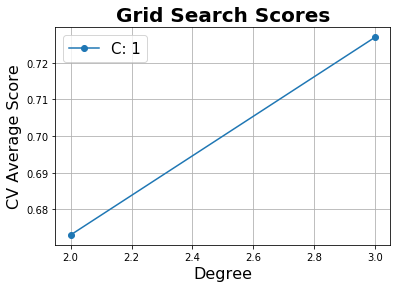

In [12]:
plot_grid_search(clf.cv_results_, degree, [1000], "Degree", "C")

In [18]:
clf.score(encoded_test_clean, y_test)

0.7278574962889659

In [19]:
clf.score(encoded_test_noisy, y_test)

0.6556160316674914